# FashionMNIST Image Classification using CNNs (PyTorch)

In this project, we will build and train a **Convolutional Neural Network (CNN)** to classify images from the **FashionMNIST** dataset.

## Project Objectives

- Load and preprocess the FashionMNIST dataset  
- Build a simple CNN from scratch  
- Train the model and monitor performance  
- Evaluate using accuracy and confusion matrix  
- Visualize learning curves

## Dataset Information

- Image size: 28 × 28 pixels (grayscale)  
- Number of classes: 10 clothing categories (e.g., T-shirt, trouser, coat, etc.)  
- Training samples: 60,000  
- Test samples: 10,000


In [29]:
# Importing Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [30]:
# Configuration


# Image and training parameters
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28
NUM_CLASSES = 10

# Training hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 20

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")


 Using device: cuda


In [31]:
#Dataset Preparation

# Transform: convert to tensor & normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load FashionMNIST
train_val_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

print(f"Training + Validation samples: {len(train_val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Sample shape: {train_val_dataset[0][0].shape}, Label: {train_val_dataset[0][1]}")

# Split train/val (80/20)
train_size = int(0.8 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f" Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Training + Validation samples: 60000
Test samples: 10000
Sample shape: torch.Size([1, 28, 28]), Label: 9
 Train: 48000, Val: 12000, Test: 10000


In [32]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, img_height, img_width):
        super(SimpleCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        # Calculate flattened size dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, img_height, img_width)
            x = self.pool1(self.relu1(self.conv1(dummy_input)))
            x = self.pool2(self.relu2(self.conv2(x)))
            self._to_linear = x.view(1, -1).shape[1]

        # Fully connected layer
        self.fc = nn.Linear(self._to_linear, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Initialize model
model = SimpleCNN(NUM_CLASSES, IMAGE_HEIGHT, IMAGE_WIDTH).to(device)
print(model)


SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


In [34]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(NUM_EPOCHS):
    # ---- TRAIN ----
    model.train()
    total_train, correct_train, train_loss_sum = 0, 0, 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_train_loss = train_loss_sum / len(train_loader.dataset)
    epoch_train_acc = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # ---- VALIDATION ----
    model.eval()
    total_val, correct_val, val_loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss_sum += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    epoch_val_loss = val_loss_sum / len(val_loader.dataset)
    epoch_val_acc = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | "
          f"Train Loss: {epoch_train_loss:.4f}, Acc: {epoch_train_acc:.2f}% | "
          f"Val Loss: {epoch_val_loss:.4f}, Acc: {epoch_val_acc:.2f}%")

print(" Training completed!")


Epoch [1/20] | Train Loss: 0.5043, Acc: 82.22% | Val Loss: 0.3959, Acc: 85.79%
Epoch [2/20] | Train Loss: 0.3349, Acc: 88.06% | Val Loss: 0.3297, Acc: 88.16%
Epoch [3/20] | Train Loss: 0.2947, Acc: 89.56% | Val Loss: 0.3038, Acc: 89.38%
Epoch [4/20] | Train Loss: 0.2682, Acc: 90.52% | Val Loss: 0.2758, Acc: 90.29%
Epoch [5/20] | Train Loss: 0.2482, Acc: 91.18% | Val Loss: 0.2685, Acc: 90.72%
Epoch [6/20] | Train Loss: 0.2334, Acc: 91.70% | Val Loss: 0.2624, Acc: 90.66%
Epoch [7/20] | Train Loss: 0.2177, Acc: 92.11% | Val Loss: 0.2652, Acc: 90.57%
Epoch [8/20] | Train Loss: 0.2072, Acc: 92.60% | Val Loss: 0.2700, Acc: 90.11%
Epoch [9/20] | Train Loss: 0.1974, Acc: 92.84% | Val Loss: 0.2573, Acc: 90.87%
Epoch [10/20] | Train Loss: 0.1888, Acc: 93.25% | Val Loss: 0.2655, Acc: 90.56%
Epoch [11/20] | Train Loss: 0.1797, Acc: 93.55% | Val Loss: 0.2674, Acc: 90.70%
Epoch [12/20] | Train Loss: 0.1717, Acc: 93.73% | Val Loss: 0.2652, Acc: 90.81%
Epoch [13/20] | Train Loss: 0.1660, Acc: 94.03% |

In [35]:
model.eval()
correct_test, total_test = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct_test += (preds == labels).sum().item()
        total_test += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct_test / total_test
print(f" Test Accuracy: {test_accuracy:.2f}%")


 Test Accuracy: 90.83%


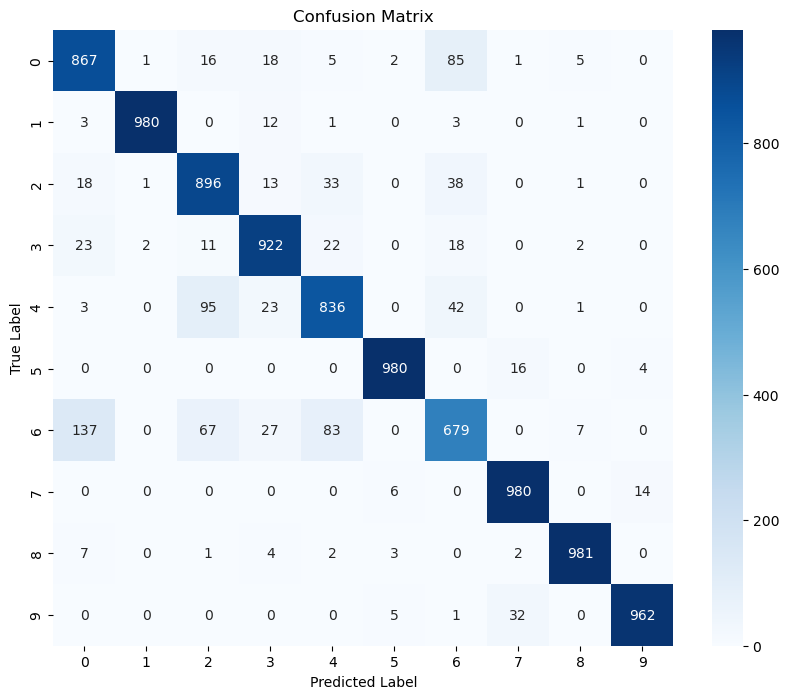

In [36]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(range(NUM_CLASSES)),
            yticklabels=list(range(NUM_CLASSES)))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


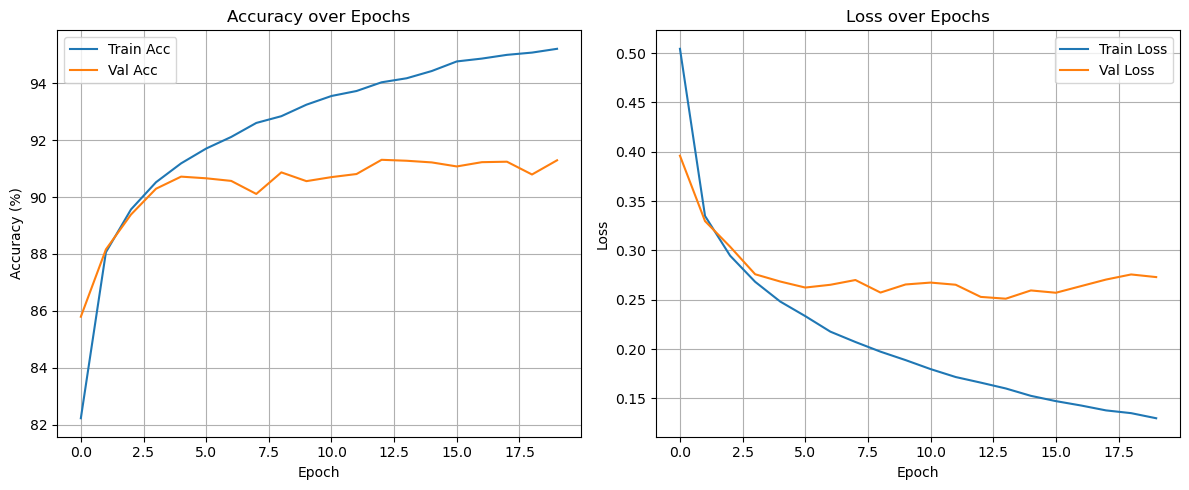

In [37]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Summary

This project implements a simple Convolutional Neural Network (CNN) to classify images from the FashionMNIST dataset.

- **Model:** Custom CNN with 2 convolutional layers and 1 fully connected layer.  
- **Dataset:** FashionMNIST (28×28 grayscale, 10 classes)  
- **Optimizer:** Adam  
- **Loss Function:** CrossEntropyLoss  
- **Training Epochs:** 20  

### Results
- **Final Training Accuracy:** 95.21%  
- **Final Validation Accuracy:** 91.29%  
- **Lowest Validation Loss:** 0.2511  
- Model shows strong generalization with stable training and minimal overfitting.

This demonstrates that even a small CNN can achieve high accuracy on FashionMNIST without heavy tuning or data augmentation.
